In [329]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 1000

def lineplot(df, x, y, xlabel=None, ylabel=None, title=None):
    """Creates a line plot from the datafram `df` using columns specified by x and y."""
    ax = df.plot(x, y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    return ax

def priceAsFloat(series):
    """Converts dollar values into float values."""
    return series.replace('[\$,]', '', regex=True).astype(float)

def plotCorrelationMatrix(df):
    """Plot correlation matrix"""
    sns.heatmap(df.corr(), annot=True, fmt=".2f")

# What is the busiest month?
Let's take a look at the availability data in `calendar.csv`

In [2]:
calendar_df = pd.read_csv('./data/seattle/calendar.csv')
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


Strip off the `$` sign from the string and convert dollar value to float.

In [3]:
calendar_df['price'] = priceAsFloat(calendar_df['price'])

Convert date string to datetime object.

In [4]:
calendar_df['ds'] = pd.to_datetime(calendar_df['date'], format='%Y-%m-%d')

Create columns for year-month and month. They'll be useful when we aggregate values by month.

In [5]:
calendar_df['year-month'] = calendar_df['ds'].map(lambda x: x.strftime('%Y-%m'))
calendar_df['month'] = calendar_df['ds'].map(lambda x: x.strftime('%m'))

In [6]:
print('Dataset contains listing from {} to {}'.format(calendar_df['year-month'].min(), calendar_df['year-month'].max()))

Dataset contains listing from 2016-01 to 2017-01


In [7]:
calendar_df.groupby('year-month').count()

,listing_id,date,available,price,ds,month
year-month,,,,,,
2016-01,106904,106904,106904,59239,106904,106904
2016-02,110722,110722,110722,73321,110722,110722
2016-03,118358,118358,118358,83938,118358,118358
2016-04,114540,114540,114540,76037,114540,114540
2016-05,118358,118358,118358,79971,118358,118358
2016-06,114540,114540,114540,77244,114540,114540
2016-07,118358,118358,118358,74222,118358,118358
2016-08,118358,118358,118358,76347,118358,118358
2016-09,114540,114540,114540,77246,114540,114540


2017-01 has MUCH fewer listing than other months. There seems to be missing data here. For the purpose of this analysis, we can eliminate the entire month and focus on 2016. 

In [8]:
calendar_df = calendar_df[calendar_df['year-month']!='2017-01']

In [9]:
calendar_df.groupby('listing_id').price.nunique().head()

listing_id
3335     1
4291     1
5682    10
6606     2
7369     1
Name: price, dtype: int64

Listings look like they are repeated, so it appears that `calender.csv` contains day-to-day availability of each listing.

Convert `available` to numerical column so we can use aggregation to get the total number of listings and count the number of available listings.

In [10]:
available_df = calendar_df[['month', 'available']]
available_df['available'] = available_df.apply(lambda x: 1 if x['available']=='t' else 0, 1)

C:\Users\Kenny\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
available_df.head(2)

,month,available
0,01,1
1,01,1


Calculate percent available per month. That requires getting a count of all listings and a count of listings that were available.

In [12]:
available_per_month_df = available_df.groupby('month').agg(['sum', 'count'])
available_per_month_df.columns=['available_listings', 'total_listings']
available_per_month_df = available_per_month_df.reset_index()
available_per_month_df['percent_available'] = 100 * (available_per_month_df['available_listings']/available_per_month_df['total_listings'])


In [13]:
available_per_month_df

,month,available_listings,total_listings,percent_available
0,01,59239,106904,55.413268
1,02,73321,110722,66.220805
2,03,83938,118358,70.918738
3,04,76037,114540,66.384669
4,05,79971,118358,67.567042
5,06,77244,114540,67.438449
6,07,74222,118358,62.709745
7,08,76347,118358,64.505145
8,09,77246,114540,67.440196
9,10,82438,118358,69.651397


In [14]:
available_per_month_df['total_listings'].describe()

count        12.000000
mean     115494.500000
std        3685.543268
min      106904.000000
25%      114540.000000
50%      116449.000000
75%      118358.000000
max      118358.000000
Name: total_listings, dtype: float64

The average number of listings is 115k and the STD is 3.6k. That isn't enough variation to suggests that some months have more listing than other months.
However, looks like **inventory** is lowest in January and highest in December.

In [15]:
available_per_month_df['total_listings'].min()/available_per_month_df['total_listings'].max()

0.9032258064516129

Inventory in lowest month is roughly 90% of inventory in the highest month. 

## Plot monthly availability

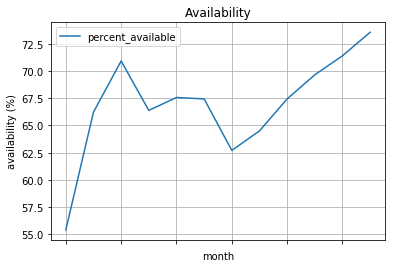

In [300]:
lineplot(available_per_month_df, 'month', 'percent_available', 
         xlabel='month', ylabel='availability (%)', title='Availability')

January has the lowest availability. Demand is higher than other month in the year. Keep mind that January also has the lowest inventory.

Plot daily availability in January

In [17]:
jan_availability_df = calendar_df[calendar_df['month']=='01'][['ds', 'available']]
jan_availability_df['available'] = jan_availability_df.apply(lambda x: 1 if x['available']=='t' else 0, 1)
jan_availibility_per_day_df = jan_availability_df.groupby('ds').agg(['sum', 'count'])
jan_availibility_per_day_df.columns=['available_listings', 'total_listings']
jan_availibility_per_day_df = jan_availibility_per_day_df.reset_index()
jan_availibility_per_day_df['percent_available'] = (100.0 * jan_availibility_per_day_df['available_listings'])/jan_availibility_per_day_df['total_listings']


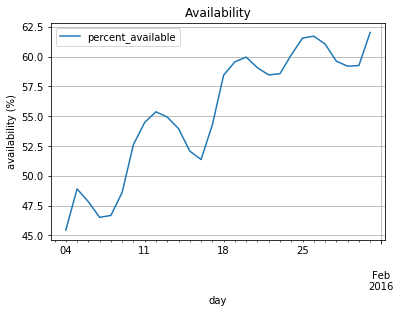

In [302]:
lineplot(jan_availibility_per_day_df, 'ds', 'percent_available', 
         xlabel='day', ylabel='availability (%)', title='Availability')

Demand is highest at the beginning of the year. Plot shows that inventory starts low in January and then increases. It could related to the New Year and hosts are away or occupied with family during that time. 

# What Factors affect rating?
We want to answer this question because it's important for hosts to maintain the highest rating.
`listing.csv` contains review scores, let's dive in and see we can find anything that drives the overall rating of the rental.

In [19]:
listing_df = pd.read_csv('./data/seattle/listings.csv')

In [20]:
listing_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,"Make your self at home in this charming one-bedroom apartment, centrally-located on the west side of Queen Anne hill. This elegantly-decorated, completely private apartment (bottom unit of a duplex) has an open floor plan, bamboo floors, a fully equipped kitchen, a TV, DVD player, basic cable, and a very cozy bedroom with a queen-size bed. The unit sleeps up to four (two in the bedroom and two on the very comfortable fold out couch, linens included) and includes free WiFi and laundry. The apartment opens onto a private deck, complete with it's own BBQ, overlooking a garden and a forest of black bamboo. The Apartment is perfectly-located just one block from the bus lines where you can catch a bus and be downtown Seattle in fifteen minutes or historic Ballard in ten or a quick five-minute walk will bring you to Whole Foods and Peet's Coffee or take a fifteen minute walk to the top of Queen Anne Hill where you will find a variety of eclectic shops, bars, and restaurants. There i...","Make your self at home in this charming one-bedroom apartment, centrally-located on the west side of Queen Anne hill. This elegantly-decorated, completely private apartment (bottom unit of a duplex) has an open floor plan, bamboo floors, a fully equipped kitchen, a TV, DVD player, basic cable, and a very cozy bedroom with a queen-size bed. The unit sleeps up to four (two in the bedroom and two on the very comfortable fold out couch, linens included) and includes free WiFi and laundry. The apartment opens onto a private deck, complete with it's own BBQ, overlooking a garden and a forest of black bamboo. The Apartment is perfectly-located just one block from the bus lines where you can catch a bus and be downtown Seattle in fifteen minutes or historic Ballard in ten or a quick five-minute walk will bring you to Whole Foods and Peet's Coffee or take a fifteen minute walk to the top of Queen Anne Hill where you will find a variety of eclectic shops, bars, and restaurants. There i...",none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/cfe47d69_original.jpg?interpolation=lanczos-none&size=large_cover&output-format=jpg&output-quality=70,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a small landscape business. My life revolves around beauty wherever I find it or create it. I grew up in Seattle and love this city for the people, it's natural beauty and don't know anywhere el

In [21]:
listing_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

Convert dollar values into float values.

In [22]:
listing_df['price'] = priceAsFloat(listing_df['price'])
listing_df['weekly_price'] = priceAsFloat(listing_df['weekly_price'])
listing_df['monthly_price'] = priceAsFloat(listing_df['monthly_price'])
listing_df['security_deposit'] = priceAsFloat(listing_df['security_deposit'])
listing_df['cleaning_fee'] = priceAsFloat(listing_df['cleaning_fee'])
listing_df['extra_people'] = priceAsFloat(listing_df['extra_people'])

In [23]:
print('number of listings:', listing_df.shape[0])

number of listings: 3818


In [24]:
print('Average rental price $%.2f' % listing_df['price'].mean(), 'mean rental price: $%.2f' % listing_df['price'].median())

Average rental price $127.98 mean rental price: $100.00


In [25]:
listing_df['price'].describe()

count    3818.000000
mean      127.976166
std        90.250022
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64

Std is \$90 that's a big spread. That means we can't relie on average price to predict similar rentals. Note that few rentals are above $150.

Checking for null values and see how sparse the data is. If data we need contains missing values, we need to determine whether to impute or drop columns.

In [26]:
column_sparsity_df = pd.DataFrame(listing_df.isnull().mean()).reset_index()
column_sparsity_df.columns = ['col_name', 'sparsity']
column_sparsity_df.sort_values('sparsity')


,col_name,sparsity
0,id,0.000000
57,price,0.000000
55,amenities,0.000000
54,bed_type,0.000000
50,accommodates,0.000000
49,room_type,0.000000
47,is_location_exact,0.000000
62,guests_included,0.000000
46,longitude,0.000000
44,country,0.000000


In [27]:
column_sparsity_df[column_sparsity_df['sparsity'] < 0.4]['col_name'].nunique()

86

In [28]:
column_sparsity_df[column_sparsity_df['sparsity'] < 0.4]['col_name'].tolist()

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'transit',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'price',
 'cleaning_fee',
 'guests_included',
 'extr

It doesn't look like the columns we're interested in, the review_scores columns, only have few null values. 

There are only few features related to review scores. To see what factors drive the overall rating, we can compute the correlation of each feature to the overall rating.

In [29]:
ratings_df = listing_df[['review_scores_rating',
'review_scores_accuracy',
'review_scores_cleanliness',
'review_scores_checkin',
'review_scores_communication',
'review_scores_value',
]]

In [30]:
ratings_df.describe()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_value
count,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3162.000000
mean,94.539262,9.636392,9.556398,9.786709,9.809599,9.452245
std,6.606083,0.698031,0.797274,0.595499,0.568211,0.750259
min,20.000000,2.000000,3.000000,2.000000,2.000000,2.000000
25%,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000
50%,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000
75%,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000
max,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [76]:
ratings_df.isnull().mean()

review_scores_rating           0.169460
review_scores_accuracy         0.172342
review_scores_cleanliness      0.171032
review_scores_checkin          0.172342
review_scores_communication    0.170508
review_scores_value            0.171818
dtype: float64

There are some values that are missing. Their quantiles suggest that they do not have a lot of variation, but let's see why they are missing.

In [82]:
ratings_df.head(10)

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_value
0,95.0,10.0,10.0,10.0,10.0,10.0
1,96.0,10.0,10.0,10.0,10.0,10.0
2,97.0,10.0,10.0,10.0,10.0,10.0
3,NaN,NaN,NaN,NaN,NaN,NaN
4,92.0,9.0,9.0,10.0,10.0,9.0
5,95.0,10.0,10.0,10.0,10.0,10.0
6,99.0,10.0,10.0,10.0,10.0,10.0
7,97.0,10.0,10.0,10.0,10.0,10.0
8,97.0,10.0,9.0,10.0,9.0,10.0
9,97.0,10.0,10.0,10.0,10.0,9.0


So it seems that the rows with null ratings are the ones that don't have them. Since there a few rows with null ratings and the data is dense, we can drop null values.

In [83]:
ratings_df.dropna(inplace=True)

C:\Users\Kenny\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [84]:
ratings_df.corr()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_value
review_scores_rating,1.000000,0.622438,0.642380,0.521914,0.543626,0.696288
review_scores_accuracy,0.622438,1.000000,0.544217,0.407205,0.423786,0.563959
review_scores_cleanliness,0.642380,0.544217,1.000000,0.398625,0.388338,0.524236
review_scores_checkin,0.521914,0.407205,0.398625,1.000000,0.696322,0.403223
review_scores_communication,0.543626,0.423786,0.388338,0.696322,1.000000,0.464171
review_scores_value,0.696288,0.563959,0.524236,0.403223,0.464171,1.000000


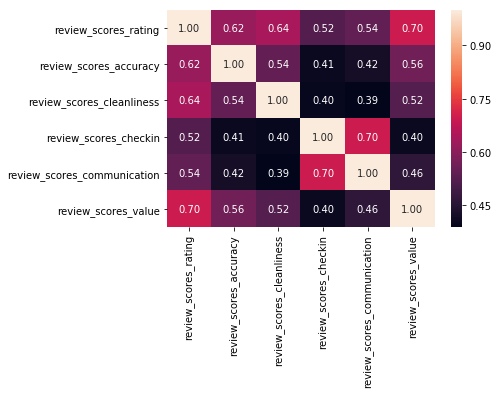

In [327]:
plotCorrelationMatrix(ratings_df)

Highest correlation to rating are `value` and `cleanliness`.
Hosts should make it a priority to make sure the place is clean and provide as much value as possible.

I'm curious to see what value correspond to value here. My guess is it's related to amenities. Let's parse the `amenities` column and find out. We'll need to one-hot encode each amenity value and see if there is any of them that correlates to rating.

In [314]:
amentity_value_df = listing_df[['amenities', 'review_scores_value']]
cleansed_amenity_values = amentity_value_df['amenities'].replace('[{}\"]', '', regex=True).str

In [315]:
from collections import Counter
counts = cleansed_amenity_values.split(',').map(Counter).sum()

In [316]:
counts.keys()

dict_keys(['TV', 'Cable TV', 'Internet', 'Wireless Internet', 'Air Conditioning', 'Kitchen', 'Heating', 'Family/Kid Friendly', 'Washer', 'Dryer', 'Free Parking on Premises', 'Buzzer/Wireless Intercom', 'Smoke Detector', 'Carbon Monoxide Detector', 'First Aid Kit', 'Safety Card', 'Fire Extinguisher', 'Essentials', 'Pets Allowed', 'Pets live on this property', 'Dog(s)', 'Cat(s)', 'Hot Tub', 'Indoor Fireplace', 'Shampoo', 'Breakfast', '24-Hour Check-in', 'Hangers', 'Hair Dryer', 'Iron', 'Laptop Friendly Workspace', 'Suitable for Events', 'Elevator in Building', 'Lock on Bedroom Door', 'Wheelchair Accessible', 'Gym', '', 'Pool', 'Smoking Allowed', 'Other pet(s)', 'Doorman', 'Washer / Dryer'])

In [317]:
amenity_dummies = cleansed_amenity_values.get_dummies(sep=',')

In [318]:
amentity_value_df = pd.concat([amentity_value_df, amenity_dummies], axis=1)

In [319]:
amentity_value_df.head(2)

,amenities,review_scores_value,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,Dryer,Elevator in Building,Essentials,Family/Kid Friendly,Fire Extinguisher,First Aid Kit,Free Parking on Premises,Gym,Hair Dryer,Hangers,Heating,Hot Tub,Indoor Fireplace,Internet,Iron,Kitchen,Laptop Friendly Workspace,Lock on Bedroom Door,Other pet(s),Pets Allowed,Pets live on this property,Pool,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet
0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""Air Conditioning"",Kitchen,Heating,""Family/Kid Friendly"",Washer,Dryer}",10.0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1
1,"{TV,Internet,""Wireless Internet"",Kitchen,""Free Parking on Premises"",""Buzzer/Wireless Intercom"",Heating,""Family/Kid Friendly"",Washer,Dryer,""Smoke Detector"",""Carbon Monoxide Detector"",""First Aid Kit"",""Safety Card"",""Fire Extinguisher"",Essentials}",10.0,0,0,0,1,0,1,0,0,0,1,0,1,1,1,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1


Count total number of amenities 

In [320]:
amentity_value_df['amenity_count'] = cleansed_amenity_values.split(',').map(lambda x: len(x))

In [321]:
amentity_value_df.isnull().mean()

amenities                     0.000000
review_scores_value           0.171818
24-Hour Check-in              0.000000
Air Conditioning              0.000000
Breakfast                     0.000000
Buzzer/Wireless Intercom      0.000000
Cable TV                      0.000000
Carbon Monoxide Detector      0.000000
Cat(s)                        0.000000
Dog(s)                        0.000000
Doorman                       0.000000
Dryer                         0.000000
Elevator in Building          0.000000
Essentials                    0.000000
Family/Kid Friendly           0.000000
Fire Extinguisher             0.000000
First Aid Kit                 0.000000
Free Parking on Premises      0.000000
Gym                           0.000000
Hair Dryer                    0.000000
Hangers                       0.000000
Heating                       0.000000
Hot Tub                       0.000000
Indoor Fireplace              0.000000
Internet                      0.000000
Iron                     

In [322]:
amentity_value_df.corr()['review_scores_value'].sort_values()

Elevator in Building         -0.070036
Buzzer/Wireless Intercom     -0.054980
Gym                          -0.039458
Pool                         -0.036289
Suitable for Events          -0.036046
Washer / Dryer               -0.034434
Washer                       -0.028940
Kitchen                      -0.026659
Hot Tub                      -0.026492
Dryer                        -0.023942
Family/Kid Friendly          -0.023092
Wheelchair Accessible        -0.016861
Pets Allowed                 -0.016830
Internet                     -0.009472
Smoking Allowed              -0.005094
Cable TV                      0.004948
Other pet(s)                  0.005655
Doorman                       0.006531
Air Conditioning              0.010850
Heating                       0.015374
Iron                          0.017524
Hangers                       0.023803
24-Hour Check-in              0.026066
Hair Dryer                    0.027650
Lock on Bedroom Door          0.036226
TV                       

It doesn't look like amenities are correlated to the score for value.

# What factors affect price?

In [259]:
# Choosing our predictors
price_df = listing_df[['neighbourhood_cleansed',
'zipcode',
'property_type',
'room_type',
'accommodates',
'bathrooms',
'bedrooms',
'minimum_nights',
'price'
]]

In [260]:
price_df.drop_duplicates(inplace=True)

C:\Users\Kenny\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [261]:
price_df['price'].mean()

130.00938189845473

In [262]:
price_df.shape

(3624, 9)

In [263]:
price_df.isnull().mean()

neighbourhood_cleansed    0.000000
zipcode                   0.001932
property_type             0.000276
room_type                 0.000000
accommodates              0.000000
bathrooms                 0.003863
bedrooms                  0.001656
minimum_nights            0.000000
price                     0.000000
dtype: float64

In [264]:
price_df[price_df['bathrooms'].isna()].head(5)

,neighbourhood_cleansed,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,minimum_nights,price
1242,Belltown,98121,Apartment,Entire home/apt,4,NaN,1.0,2,107.0
1314,Belltown,98121,Apartment,Entire home/apt,4,NaN,1.0,2,135.0
1357,Belltown,98121,Apartment,Entire home/apt,6,NaN,2.0,2,186.0
1378,Belltown,98121,Apartment,Entire home/apt,4,NaN,1.0,1,149.0
1961,Greenwood,98117,House,Private room,4,NaN,1.0,1,280.0


In [265]:
price_df[price_df['bedrooms'].isna()].head(5)

,neighbourhood_cleansed,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,minimum_nights,price
1429,Belltown,98121,Apartment,Entire home/apt,2,1.0,NaN,1,80.0
1492,Central Business District,98101,Apartment,Entire home/apt,6,1.0,NaN,1,200.0
1493,Central Business District,98101,Other,Entire home/apt,4,1.0,NaN,1,132.0
1853,Fairmount Park,98136,Apartment,Entire home/apt,2,1.0,NaN,2,95.0
2619,Broadway,98102,House,Entire home/apt,2,1.0,NaN,2,99.0


Some rows have missing values for bathrooms and bedrooms. These are numerical values that can be imputed. There aren't lot of missing values and given that values for bathrooms and bedrooms are small in range (0-8), we can safely use the average for them.

In [266]:
price_df.fillna(price_df.mean(), inplace=True)

C:\Users\Kenny\Anaconda3\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [267]:
price_df['price'].describe()

count    3624.000000
mean      130.009382
std        91.564200
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64

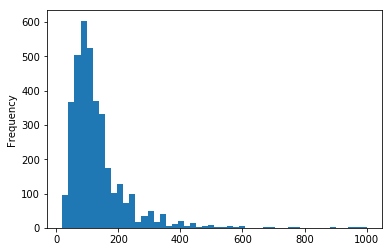

In [268]:
price_df['price'].plot.hist(bins=50)

Most of the prices are in the low $100.

See how many unique values there are for each column

In [269]:
price_df.nunique()

neighbourhood_cleansed     87
zipcode                    28
property_type              16
room_type                   3
accommodates               15
bathrooms                  13
bedrooms                    9
minimum_nights             22
price                     273
dtype: int64

In [270]:
price_df.describe()

,accommodates,bathrooms,bedrooms,minimum_nights,price
count,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000
mean,3.399283,1.266898,1.326147,2.398731,130.009382
std,1.994281,0.594643,0.895468,16.734659,91.564200
min,1.000000,0.000000,0.000000,1.000000,20.000000
25%,2.000000,1.000000,1.000000,1.000000,75.000000
50%,3.000000,1.000000,1.000000,2.000000,100.000000
75%,4.000000,1.000000,2.000000,2.000000,150.000000
max,16.000000,8.000000,7.000000,1000.000000,1000.000000


In [271]:
price_df.corr()['price'].sort_values(ascending=False)

price             1.000000
accommodates      0.646535
bedrooms          0.627650
bathrooms         0.524963
minimum_nights    0.016754
Name: price, dtype: float64

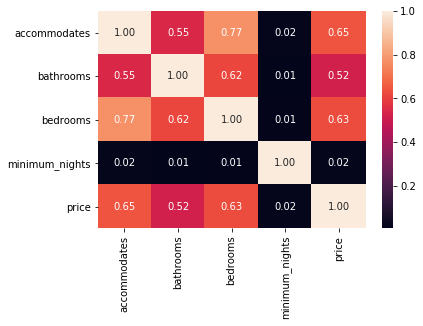

In [328]:
plotCorrelationMatrix(price_df)

Accommodates and bedrooms have the strongest positive correlation to price. Let's use regressions to validate the positive correlations.

Text(0.5,1,'Price vs Accommodates')

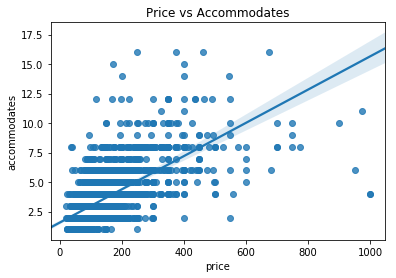

In [273]:
ax = sns.regplot(x=price_df['price'], y=price_df['accommodates'])
ax.set_title('Price vs Accommodates')

Text(0.5,1,'Price vs Bedroom')

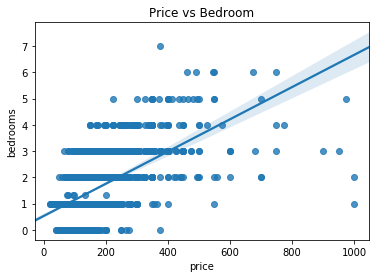

In [274]:
ax = sns.regplot(x=price_df['price'], y=price_df['bedrooms'])
ax.set_title('Price vs Bedroom')

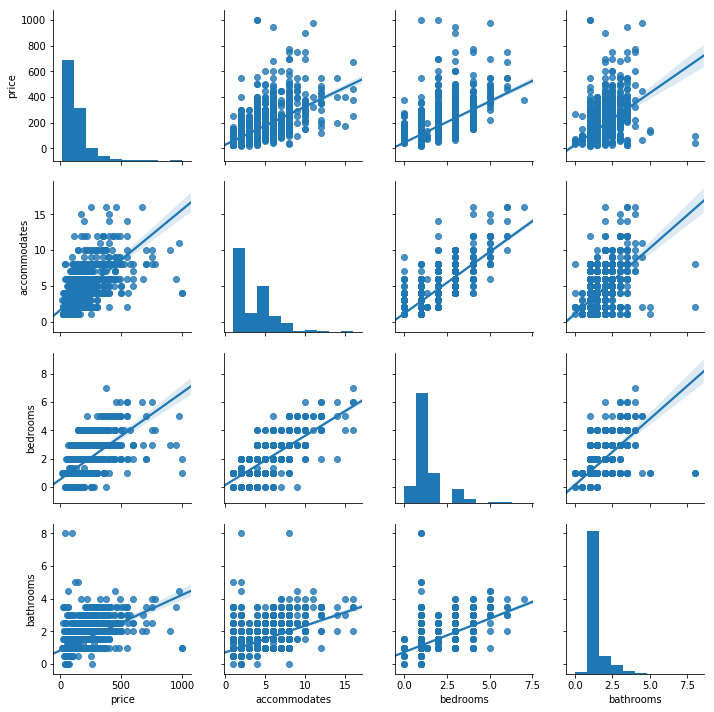

In [275]:
sns.pairplot(price_df[['price', 'accommodates', 'bedrooms', 'bathrooms']], kind='reg')


The takeaway from these plots is that the more people the rental can accommodates and the more bedrooms it has, the higher the price.

# How much can we list a 3b/2b home? 

In order to answer this question, let's see what the stats for properties that are 3b/2b

In [276]:
average_3b2b_prices = price_df[
    (price_df['bathrooms']==2) & 
    (price_df['bedrooms']==3)
]['price']
print('The average list price for a 3b/2b is $%3.2f' % average_3b2b_prices.mean())

The average list price for a 3b/2b is $245.21


In [277]:
average_3b2b_prices.describe()

count     97.000000
mean     245.206186
std      115.095607
min       65.000000
25%      175.000000
50%      225.000000
75%      295.000000
max      899.000000
Name: price, dtype: float64

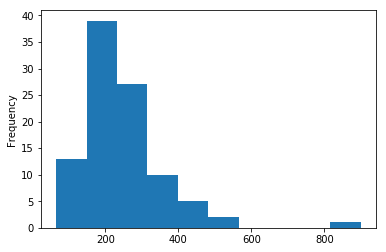

In [278]:
average_3b2b_prices.plot(kind='hist')

Most of 3b/2b properties are in the \$200-\$250 range. 

# Build a Pricing ML Model

We'll go a step further and train RandomForestRegressor and see if we can make prediction based on the property's size and location. We have so far calculated the average price of 3b2b property. This has limited application. If we want to calculate the price for 1b1b, we'd need to do it by hand. Also, we want to consider the type of property, apartment vs house, whether or not the property is located in a good neighborhood, etc. If we have to include all these dimensions in our price calculation, it would infeasible to do by hand. Using ML has the advantage of taking this burden away from us. Once the model is learned, it can then be deployed to programmatically help hosts set custom prices for their rentals.

First, we need to one-hot encode categorical values. This process will convert category into columns and assign numerical values (binary) for each category, so that they can be passed into our ML model.

In [279]:
neighborhood_dummies = pd.get_dummies(price_df['neighbourhood_cleansed'], prefix='neighbourhood', drop_first=True)
zipcode_dummies = pd.get_dummies(price_df['zipcode'], prefix='zipcode', drop_first=True)
property_type_dummies = pd.get_dummies(price_df['property_type'], prefix='property_type', drop_first=True)
room_type_dummies = pd.get_dummies(price_df['room_type'], prefix='room_type', drop_first=True)


Creating features and labels for our model.

In [280]:
X = pd.concat(
    [price_df[['accommodates', 'bathrooms', 'bedrooms', 'minimum_nights']], 
    neighborhood_dummies,
    zipcode_dummies,
    property_type_dummies,
    room_type_dummies
    ],
    axis=1
)

y = price_df['price']

In [281]:
from sklearn.model_selection import train_test_split

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [323]:
def calculate_metrics(y_pred, y_test):
    """Calculate MAE and Accuracy of prediction given ground truth"""
    errors = abs(y_pred - y_test)
    mae = np.mean(errors)
    mape = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mape)
    return (mae, accuracy)

Create a baseline and make the model we train outperforms it.
The baseline is simply the average price.

In [284]:
avg = np.mean(y_test)
baseline_pred = np.ones(y_test.shape) * avg

In [285]:
mae, accuracy = calculate_metrics(baseline_pred, y_test)
print('Baseline MAE: $%5.2f' % mae)
print('Baseline Accuracy: %2.1f' % accuracy, '%')

Baseline MAE: $62.35
Baseline Accuracy: 38.4 %


Begin training model

In [286]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [287]:
forest = RandomForestRegressor(
    n_estimators=1000, 
    max_depth = 80,
    max_features = 3,
    min_samples_leaf = 5,
    min_samples_split = 2,
    n_jobs=-1, 
    random_state=0,
    criterion='mae'
)
forest.fit(X_train, y_train)



RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [288]:
forest.feature_importances_.tolist()

[0.17316206591627448,
 0.13049657580338306,
 0.1710667434608636,
 0.05416469116677119,
 0.004989158217585951,
 0.0,
 0.0006782727295082256,
 0.024955253216145553,
 0.002280780899934123,
 0.003929614859594231,
 0.00024164613452770138,
 0.0003499077475995458,
 0.0008966225772393871,
 0.0006885016730175612,
 3.099914458003897e-05,
 0.016855051992484424,
 0.0019718624344831613,
 0.0009160849113527351,
 0.0018271311404682421,
 0.003296437221888535,
 0.0002619948331629739,
 0.0009940031732489944,
 0.00017197497246705572,
 0.0067866777246355925,
 0.0003828630209509101,
 0.0005139490620442954,
 0.001837802354388632,
 0.0006741226254277468,
 0.0007216095332185981,
 0.0030232077819906723,
 9.610162052626718e-05,
 0.00016261007129002967,
 0.0008822039625861751,
 0.00020280736746626103,
 0.0,
 0.0,
 1.853732230487859e-05,
 0.0007090969623808378,
 3.4387430428527864e-05,
 0.0005236725197214445,
 0.0006096808050781927,
 0.004981251271329797,
 0.0009412005993953645,
 0.0006538215910109569,
 0.0011701

The highest feature importance is 0.0077 which corresponds to `bedrooms`. This confirms our previous finding that number of bedrooms is a good predictor of price.

In [289]:
y_pred = forest.predict(X_test)

In [290]:
# Calculate the MAE and Accuracy
mae, accuracy = calculate_metrics(y_pred, y_test)
print('Initial model MAE: $%5.2f' % mae)
print('Initial model Accuracy: %2.1f' % accuracy, '%')


Initial model MAE: $46.20
Initial model Accuracy: 63.8 %


### Searching for the best parameters

In [291]:
param_grid = {
    'criterion': ['mae'],
    'max_depth': [100, 150, 200],
    'max_features': [10, 15, 20],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [200, 300, 500]
}

In [292]:
grid_search = GridSearchCV(estimator=forest,
                          param_grid=param_grid,
                          scoring='neg_mean_absolute_error',
                          cv=5,
                          n_jobs=20,
                          verbose=3)

In [293]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:  7.0min
[Parallel(n_jobs=20)]: Done 248 tasks      | elapsed: 19.2min
[Parallel(n_jobs=20)]: Done 472 tasks      | elapsed: 38.9min
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed: 62.6min
[Parallel(n_jobs=20)]: Done 1112 tasks      | elapsed: 91.0min
[Parallel(n_jobs=20)]: Done 1215 out of 1215 | elapsed: 98.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=20,
       param_grid={'criterion': ['mae'], 'max_depth': [100, 150, 200], 'max_features': [10, 15, 20], 'min_samples_leaf': [1, 3, 5], 'min_samples_split': [2, 4, 8], 'n_estimators': [200, 300, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=3)

In [294]:
grid_search.best_params_

{'criterion': 'mae',
 'max_depth': 100,
 'max_features': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 200}

In [295]:
best_forest = grid_search.best_estimator_


In [296]:
y_pred = best_forest.predict(X_test)
mae, accuracy = calculate_metrics(y_pred, y_test)
print('Best model MAE: $%5.2f' % mae)
print('Best model Accuracy: %2.1f' % accuracy, '%')


Best model MAE: $34.08
Best model Accuracy: 72.4 %
